In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [41]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data = np.array(data)
m, n = data.shape
data = data.T

In [42]:
label = data[0]
img = data[1:n]
img.shape

(784, 42000)

In [43]:
img_data = img
img_data = np.reshape(img_data, (28,28,42000))

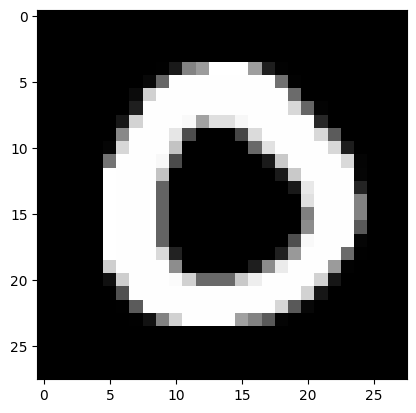

In [44]:
img_index = 4
plt.gray()
plt.imshow(img_data[:,:,img_index], interpolation='nearest')
plt.show()

In [45]:
def conv(image, kernel): # Convolution function
    img_row = image.shape[0]
    img_col = image.shape[1]
    
    k_row = kernel.shape[0]
    k_col = kernel.shape[1]
    
    conv_row = img_row - k_row + 1
    conv_col = img_col - k_col + 1
    shape = (conv_row, conv_col, 42000)
    
    image_conv = np.zeros(shape)
    
    center = (k_row//2, k_col//2)
    
    for m in range(center[0], img_row-center[0]):
        for n in range(center[1], img_col-center[1]):
            
            for i in range(-center[0],center[0]+1):
                for j in range(-center[1],center[1]+1):
                    image_conv[m-center[0],n-center[1]] += kernel[center[0]+i,center[1]+j]*image[m+i,n+j]
                    
    return image_conv

def back_conv(image, error): #Backprobagation convolution
    img_row = image.shape[0]
    img_col = image.shape[1]
    
    e_row = error.shape[0]
    e_col = error.shape[1]
    
    conv_row = img_row - e_row + 1
    conv_col = img_col - e_col + 1
    shape = (conv_row, conv_col, 42000)
    
    
    image_conv = np.zeros(shape)
    
    center = (e_row//2, e_col//2)
    
    for m in range(center[0], img_row-center[0]+1):
        for n in range(center[1], img_col-center[1]+1):
            
            for i in range(-center[0],center[0]):
                for j in range(-center[1],center[1]):
                    image_conv[m-center[0],n-center[1]] += error[center[0]+i,center[1]+j]*image[m+i,n+j]
                    
    return image_conv

def ReLU(Z):
    return np.maximum(Z,0)

def deriv_ReLU(Z):
    return Z > 0

def softmax(Z):
    return np.exp(Z)/sum(np.exp(Z))

def kernel_init(ktype):
    if (ktype == 'BoxBlur'):
        return np.matrix([[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]])
    if (ktype == 'Ridge'):
        return np.matrix([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    if (ktype == 'Edge'):
        return np.matrix([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    if (ktype == 'Sharp'):
        return np.matrix([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    if (ktype == 'Gauss3'):
        return 1/16*np.matrix([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
    if (ktype == 'Gauss5'):
        return 1/256*np.matrix([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [1, 4, 6, 4, 1], [4, 16, 24, 16, 4]])
    if (ktype == 'Rand3'):
        return 1/255 * np.random.randint(low=0, high=255, size=(3,3))
    if (ktype == 'Rand5'):
        return 1/255 * np.random.randint(low=0, high=255, size=(5,5))
    return f"{ktype} is not a valid kernel name"

def param_init():
    W1 = kernel_init('Rand5')-0.5
    #b1 = 1/255*np.random.randint(low=0, high=255, size = (28-W1.shape[0]+1,28-W1.shape[1]+1,1))-0.5
    b1 = np.ones((28-W1.shape[0]+1,28-W1.shape[1]+1,1))
    #W2 = kernel_init('Rand5')-0.5
    #b2 = 1/255*np.random.randint(low=0, high=255, size = (b1.shape[0]-W1.shape[0]+1,b1.shape[0]-W1.shape[1]+1,1))-0.5
    
    W2 = 1/255*np.random.randint(low=0, high=255, size = (10,576))-0.5
    #b2 = 1/255*np.random.randint(low=0, high=255, size = (10,1))-0.5
    b2 = np.ones((10,1))
    
    return W1, b1, W2, b2

In [46]:
kernel = kernel_init('Rand5')
# BoxBlur [[1/9,1/9,1/9],[1/9,1/9,1/9],[1/9,1/9,1/9]]
# Ridge [[0, -1, 0], [-1, 4, -1], [0, -1, 0]]
# Edge [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
# Sharp [[0, -1, 0], [-1, 5, -1], [0, -1, 0]]
# Gauss3 [[1, 2, 1], [2, 4, 2], [1, 2, 1]]
# Gauss5 [[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [1, 4, 6, 4, 1], [4, 16, 24, 16, 4]]
# Rand3 & Rand5 Random initialisations of kernel of size (3x3), (5x5) respectevly

In [ ]:
img_conv = conv(img_data[:,:,img_index], kernel)
img_conv.shape

In [ ]:
plt.gray()
plt.imshow(img_conv, interpolation='nearest')
plt.show()

In [51]:
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def forward_prop(X,W1,b1,W2,b2):
    Z1 = conv(X,W1) + b1
    A1 = ReLU(Z1)
    
    A1 = np.reshape(A1, (A1.shape[0]*A1.shape[1], A1.shape[2]))
    
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    #db2 = 1 / m * np.sum(dZ2)
    db2 = np.zeros(dZ2.shape)
    dZ1 = np.reshape(W2.T.dot(dZ2) * np.reshape(deriv_ReLU(Z1), (576,42000)), (24, 24, 42000))
    dW1 = 1 / m * np.sum(back_conv(X, dZ1))
    #db1 = 1 / m * np.sum(dZ2)
    db1 = np.zeros(dZ1.shape)
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [ ]:
W1, b1, W2, b2 = param_init()
Z1 = forward_prop(img_data/255,W1,b1,W2,b2)
Z1.shape

In [48]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = param_init()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [49]:
X = img_data/255
Y = label
Y[2]

1

In [52]:
 W1, b1, W2, b2 = gradient_descent(X, Y, 0.5, 500)

Iteration:  0
[7 2 7 ... 7 7 7] [1 0 1 ... 7 6 9]
0.11419047619047619
Iteration:  10
[1 2 1 ... 0 0 9] [1 0 1 ... 7 6 9]
0.3011904761904762
Iteration:  20
[1 0 1 ... 7 6 7] [1 0 1 ... 7 6 9]
0.49538095238095237
Iteration:  30
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.6053333333333333
Iteration:  40
[1 8 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.6569047619047619
Iteration:  50
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.6471428571428571
Iteration:  60
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.6251428571428571
Iteration:  70
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.7171428571428572
Iteration:  80
[1 0 1 ... 7 6 4] [1 0 1 ... 7 6 9]
0.7078571428571429
Iteration:  90
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.7609285714285714
Iteration:  100
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.7110952380952381
Iteration:  110
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.6943095238095238
Iteration:  120
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.7322380952380952
Iteration:  130
[1 0 1 ... 7 6 9] [1 0 1 ... 7 6 9]
0.7259285714285715
Iteration:  140

In [53]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(X, W1, b1, W2, b2)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index , W1, b1, W2, b2):
    current_image = X[:,:,index]
    prediction =  make_predictions(current_image, W1, b1, W2, b2)
    label = Y[index]
    print("prediction: ", prediction)
    print("label: ", label)
    
    current_image = current_image*255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

prediction:  [4 4 4 ... 4 4 4]
label:  4


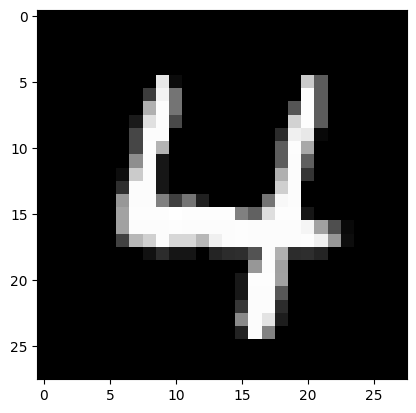

In [96]:
test_prediction(42, W1, b1, W2, b2)